# Setup libraries

In [1]:
!pip install --upgrade pip
!pip uninstall -y transformers tokenizers accelerate -q
!pip install "transformers==4.56.0" "protobuf==5.29.3" -q
!pip install torch datasets -q
!pip install pandas matplotlib seaborn tqdm wandb pyyaml
!pip install bitsandbytes accelerate
!pip install --force-reinstall --no-cache-dir "numpy<2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
peft 0.16.0 requires accelerate>=0.21.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 5.29.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 

# Config input/output path and clone latest repo

In [2]:
# Clone the latest github repo version
import os
def configure_environment_paths():
    """Detect environment and configure paths"""
    try:
        if "google.colab" in str(get_ipython()):
            print("✅ Environment: Google Colab")
            base_data_path = "/content/"
            base_output_path = "/content/output/"
            environment_name = "colab"
        elif os.environ.get("KAGGLE_KERNEL_RUN_TYPE"):
            print("✅ Environment: Kaggle")
            base_data_path = "/kaggle/input/"
            base_output_path = "/kaggle/working/"
            environment_name = "kaggle"
        else:
            print("⚠️ Environment: Local/Unknown")
            base_data_path = "./data/"
            base_output_path = "./output/"
            environment_name = "local"
    except NameError:
        print("⚠️ Non-interactive session. Using local paths.")
        base_data_path = "./data/"
        base_output_path = "./output/"
        environment_name = "local"

    os.makedirs(base_output_path, exist_ok=True)
    print(f"📂 Data Path: {base_data_path}")
    print(f"📦 Output Path: {base_output_path}")

    return base_data_path, base_output_path, environment_name

INPUT_PATH, OUTPUT_PATH, ENV_NAME = configure_environment_paths()

!rm -r -f OuroTrace
!git clone --branch antibabbling https://github.com/dzungphieuluuky/OuroTrace.git
%cd OuroTrace

✅ Environment: Kaggle
📂 Data Path: /kaggle/input/
📦 Output Path: /kaggle/working/
Cloning into 'OuroTrace'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 204 (delta 101), reused 148 (delta 52), pack-reused 0 (from 0)
Receiving objects: 100% (204/204), 502.37 KiB | 6.13 MiB/s, done.
Resolving deltas: 100% (101/101), done.
/kaggle/working/OuroTrace


In [3]:
# Suppress warnings for clean output
import warnings
import os
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
print("✅ Packages installed successfully!")

✅ Packages installed successfully!


In [4]:
"Built-in libraries"
import re
import sys
import gc
import time
import json
import hashlib
import glob
import zipfile
from io import StringIO
from datetime import datetime
from typing import Dict, List, Optional, Tuple, Any
import yaml
import logging
import random

"Deep learning and NLP libraries"
import torch
import torch.nn.functional as F
from transformers import (
    AutoConfig, 
    AutoTokenizer, 
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    GenerationConfig,
    logging as hf_logging
)

"Data processing libraries"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from tqdm.auto import tqdm
from IPython import get_ipython

# Configure logging
logging.getLogger("ContinuousBatchingLogger").setLevel(logging.ERROR)
hf_logging.set_verbosity_error()


print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
!nvidia-smi

Python Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Version: 12.4
Sun Dec 14 16:58:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8             10W /   70W |       3MiB /  15360MiB |      0%      Default |
|   

In [5]:
import pandas as pd
from src.config_loader import load_config_from_json, post_process_config
from src.runner import run_batch_experiment
from src.evaluation import analyze_experiment_results


# 1. Load Configuration from JSON
config = load_config_from_json('configs/batch_ouro_1.4b_thinking.json')


# 2. Post-process (Convert 'torch.float16' string to object, generate timestamps)
config = post_process_config(config)

# 3. Modify settings programmatically (Override JSON defaults)
config['INFERENCE_STEPS'] = [1] 

# 4. Execute
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"🕒 Timestamp: {timestamp}")
print("🚀 Starting Experiment...")
acc_results, ppl_results = run_batch_experiment(config)

🕒 Timestamp: 20251214_165856
🚀 Starting Experiment...
🔗 Initializing W&B (timeout: 30s)...
⚠️ W&B failed: 1 validation error for Settings
start_timeout
  Extra inputs are not permitted [type=extra_forbidden, input_value=30, input_type=int]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden. Continuing offline.
Generating new test datasets...

🧪 EXPERIMENT: UT Steps = 1
Loading model: UT steps=1, Early exit=-1.0


config.json: 0.00B [00:00, ?B/s]

configuration_ouro.py: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

modeling_ouro.py: 0.00B [00:00, ?B/s]

2025-12-14 16:59:02.017176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765731542.390593      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765731542.501811      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

→ Applying torch.compile()
✅ Model loaded on cuda:0
[+] FIXED Task templates with improved few-shot examples
📉 Calculating PPL...


Calculating PPL (UT=1):   0%|          | 0/8 [00:00<?, ?it/s]

W1214 17:00:03.796000 47 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


✅ PPL: 7.4645 | Loss: 2.0102

📝 Task: n_ary (20 samples)


Solving 4 requests: 100%|██████████| 4/4 [01:03<00:00, 16.00s/request]


    📊 Acc=45.00% | Time/Sample=5.918s | Total=118.4s

📝 Task: p_hop (20 samples)


Solving 4 requests: 100%|██████████| 4/4 [00:10<00:00,  2.64s/request]


    📊 Acc=25.00% | Time/Sample=2.529s | Total=50.6s

📝 Task: igsm (20 samples)


Solving 2 requests: 100%|██████████| 2/2 [00:08<00:00,  4.07s/request]

    📊 Acc=20.00% | Time/Sample=3.959s | Total=79.2s

🧠 Running Reasoning Primitives (5-shot)
  Task: var_assign_depth_0_code (50 samples)


var_assign_depth_0_code:   0%|          | 0/50 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_0_math (50 samples)


var_assign_depth_0_math:   0%|          | 0/50 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_0_equation (50 samples)


var_assign_depth_0_equation:   0%|          | 0/50 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_1_code (50 samples)


var_assign_depth_1_code:   0%|          | 0/50 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_1_math (50 samples)


var_assign_depth_1_math:   0%|          | 0/50 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_1_equation (50 samples)


var_assign_depth_1_equation:   0%|          | 0/50 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%

📚 Running Standard Benchmarks (lm-eval)
⚠️ 'lm-evaluation-harness' not installed. Skipping Standard Benchmarks.
ℹ️ To run: pip install lm-evaluation-harness



💾 Results saved to /kaggle/working/

📊 VISUALIZATION

--- Summary Statistics ---
                    is_correct_mean  is_correct_count  is_correct_std  \
ut_steps task_type                                                      
1        igsm                  0.20                20           0.410   
         n_ary                 0.45                20           0.510   
         p_hop                 0.25                20           0.444   

                    generation_time_mean  generation_time_min  \
ut_steps task_type                                              
1        igsm                      3.959                2.744   
         n_ary                     5.918                2.229   
         p_hop                     2.529                2.235   

                    generation_time_max  generated_tokens_mean  
ut_steps task_type                                              
1        igsm                     6.036                  59.60  
         n_ary                 

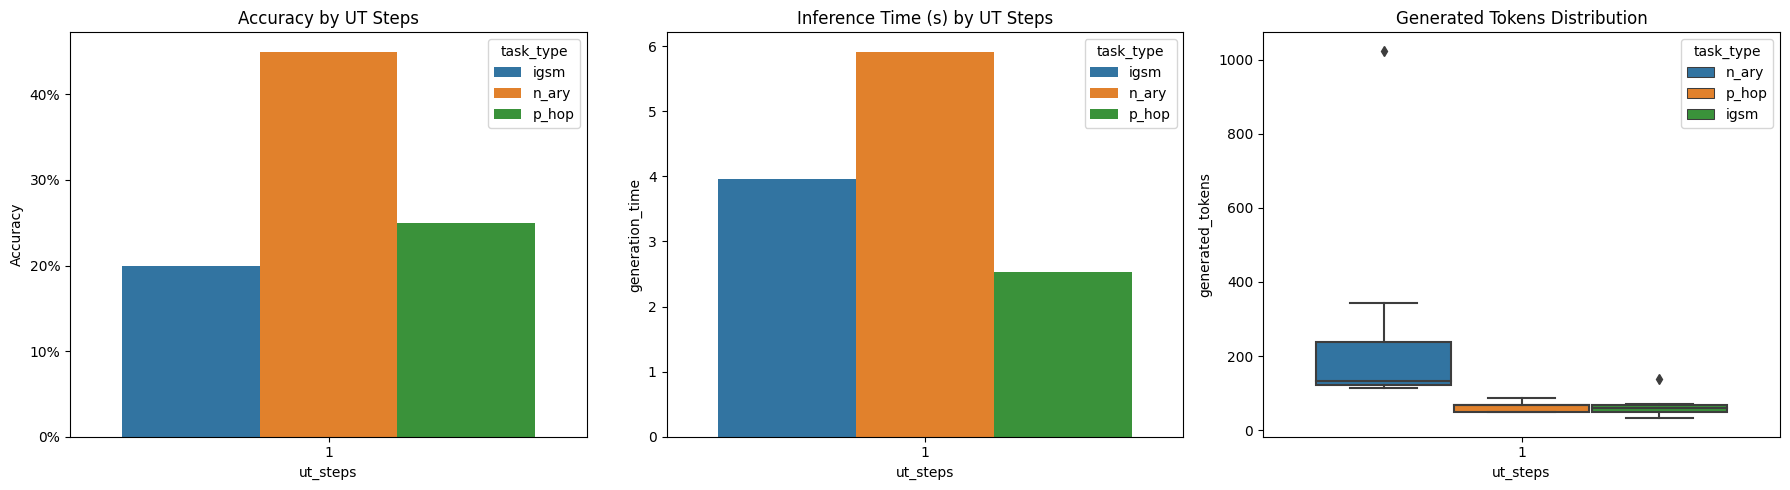


🏁 Experiment Complete.



In [6]:
# 3. Save Results
df_acc = pd.DataFrame(acc_results)
df_ppl = pd.DataFrame(ppl_results)

RUN_RESULTS_NAME = f"run_{timestamp}"
os.makedirs(os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME), exist_ok=True)
acc_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_acc_{timestamp}.csv")
ppl_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_ppl_{timestamp}.csv")
cfg_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_config_{timestamp}.yaml")

df_acc.to_csv(acc_path, index=False)
if not df_ppl.empty:
    df_ppl.to_csv(ppl_path, index=False)

# Save Config
def sanitize_config(cfg):
    """Convert config to YAML-safe format"""
    clean = {}
    for k, v in cfg.items():
        if isinstance(v, dict):
            clean[k] = sanitize_config(v)
        elif str(type(v)).find('torch.') != -1:
            clean[k] = str(v)
        else:
            clean[k] = v
    return clean

with open(cfg_path, 'w') as f:
    yaml.dump(sanitize_config(config), f)

print(f"\n💾 Results saved to {OUTPUT_PATH}")

# 4. Visualization & Reporting
if not df_acc.empty:
    print("\n" + "="*50 + "\n📊 VISUALIZATION\n" + "="*50)
    
    # Summary Tables
    # NOTE: The variable 'results_acc' is used here, assuming it holds the raw data 
    # (list of dicts) required by 'analyze_experiment_results'.
    summary = analyze_experiment_results(acc_results)
    print("\n--- Summary Statistics ---")
    print(summary)
    
    # Plotting
    try:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot 1: Accuracy
        acc_summary = df_acc.groupby(['task_type', 'ut_steps'])['is_correct'].mean().reset_index()
        sns.barplot(data=acc_summary, x='ut_steps', y='is_correct', hue='task_type', ax=axes[0])
        axes[0].set_title('Accuracy by UT Steps')
        axes[0].set_ylabel('Accuracy')
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        
        # Plot 2: Time
        time_summary = df_acc.groupby(['task_type', 'ut_steps'])['generation_time'].mean().reset_index()
        sns.barplot(data=time_summary, x='ut_steps', y='generation_time', hue='task_type', ax=axes[1])
        axes[1].set_title('Inference Time (s) by UT Steps')
        
        # Plot 3: Token Count
        sns.boxplot(data=df_acc, x='ut_steps', y='generated_tokens', hue='task_type', ax=axes[2])
        axes[2].set_title('Generated Tokens Distribution')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Visualization error: {e}")
else:
    print("⚠️ No results to visualize.")

print("\n🏁 Experiment Complete.\n")

In [7]:
import os
import glob
import zipfile

def zip_all_run_folders(output_base_path: str):
    os.makedirs(output_base_path, exist_ok=True)
    
    search_pattern = os.path.join(output_base_path, "run_*")
    run_folders = glob.glob(search_pattern)
    run_directories = [d for d in run_folders if os.path.isdir(d)]

    if not run_directories:
        print(f"⚠️ Không tìm thấy thư mục nào bắt đầu bằng 'run_' trong '{output_base_path}'.")
        return

    print(f"🔍 Tìm thấy {len(run_directories)} thư mục kết quả để nén.")
    
    successful_zips = 0

    for folder_path in run_directories:
        folder_name = os.path.basename(folder_path)
        zip_filename = os.path.join(output_base_path, f"{folder_name}.zip")
        
        try:
            print(f"\n   -> Đang nén thư mục: {folder_name}...")
            
            with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
                for root, _, files in os.walk(folder_path):
                    for file in files:
                        file_path = os.path.join(root, file)
                        arcname = os.path.relpath(file_path, os.path.dirname(folder_path))
                        zipf.write(file_path, arcname)
                        
            print(f"   ✅ Đã tạo file ZIP: {os.path.basename(zip_filename)}")
            successful_zips += 1
            
        except Exception as e:
            print(f"   ❌ Lỗi khi nén thư mục {folder_name}: {e}")

    print(f"\n✅ HOÀN TẤT! Đã nén thành công {successful_zips} trên {len(run_directories)} thư mục kết quả.")


try:
    if 'OUTPUT_PATH' in globals():
        zip_all_run_folders(OUTPUT_PATH)
    else:
        print("OUTPUT_PATH not defined.")
        
except NameError:
    print("OUTPUT_PATH not defined.")
except Exception as e:
    print(f"Đã xảy ra lỗi trong quá trình nén: {e}")

🔍 Tìm thấy 1 thư mục kết quả để nén.

   -> Đang nén thư mục: run_20251214_165856...
   ✅ Đã tạo file ZIP: run_20251214_165856.zip

✅ HOÀN TẤT! Đã nén thành công 1 trên 1 thư mục kết quả.


In [8]:
print("Final Inspection:\n")
print("Top 20 Accuracy Report:\n")
print(df_acc.head(20))
print(f"Full Response:\n")
print(df_acc['full_response'])
print("Perplexity Report:\n")
print(df_ppl.head(20))

Final Inspection:

Top 20 Accuracy Report:

   task_type difficulty                                       test_input  \
0      n_ary      4_ops                          597 + 360 + 115 + 701 =   
1      n_ary      4_ops                          045 + 975 + 189 + 511 =   
2      n_ary      4_ops                          962 + 179 + 430 + 775 =   
3      n_ary      4_ops                          870 + 152 + 304 + 286 =   
4      n_ary      4_ops                          723 + 637 + 927 + 677 =   
5      n_ary      4_ops                          142 + 663 + 295 + 263 =   
6      n_ary      4_ops                          508 + 852 + 637 + 819 =   
7      n_ary      4_ops                          344 + 512 + 081 + 659 =   
8      n_ary      4_ops                          975 + 731 + 518 + 941 =   
9      n_ary      4_ops                          794 + 339 + 969 + 007 =   
10     n_ary      8_ops  701 + 562 + 452 + 014 + 933 + 495 + 665 + 670 =   
11     n_ary      8_ops  442 + 586 + 078 + 8

In [9]:
print(df_acc[['full_response', 'generated_tokens']])

                                        full_response  generated_tokens
0   [STEP 1] Current: 0.\n[STEP 2] Add 597: 0 + 59...               128
1   [STEP 1] Current: 0.\n[STEP 2] Add 45: 0 + 45 ...               118
2   [STEP 1] Current: 0.\n[STEP 2] Add 962: 0 + 96...               132
3   [STEP 1] Current: 0.\n[STEP 2] Add 870: 0 + 87...               120
4   [STEP 1] Current: 0.\n[STEP 2] Add 723: 0 + 72...               122
5   [STEP 1] Current: 0.\n[STEP 2] Add 142: 0 + 14...               120
6   [STEP 1] Current: 0.\n[STEP 2] Add 508: 0 + 50...               122
7   [STEP 1] Current: 0.\n[STEP 2] Add 344: 0 + 34...               118
8   [STEP 1] Current: 0.\n[STEP 2] Add 975: 0 + 97...               131
9   [STEP 1] Current: 0.\n[STEP 2] Add 794: 0 + 79...               131
10  [STEP 1] Current: 0.\n[STEP 2] Add 701: 0 + 70...               342
11  [STEP 1] Current: 0.\n[STEP 2] Add 442: 0 + 44...               238
12  [STEP 1] Current: 0.\n[STEP 2] Add 200: 0 + 20...           